In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import sys

import pycomlink as pycml

**Warning**: This notebook currently depends on `poligrain` as a git submodule, pointing to my dev branch, which is currently a WIP pull-request. Hence, you need to run the git command below to get the actual code locally, or when running on binder.

In [3]:
!git submodule update --init

In [4]:
import sys
sys.path.append('poligrain/src/')

import poligrain as plg

## Load radar, CML and gauge data

In [5]:
ds_radar = xr.open_dataset('data/openMRG_example_rad.nc')
ds_radar.coords['lon'] = ds_radar.lon
ds_radar.coords['lat'] = ds_radar.lat

ds_cmls = xr.open_dataset('data/openMRG_example.nc')

ds_city_gauges = xr.open_dataset('data/openMRG_city_gauges_20150827.nc')

## Do basic CML processing

Note that this is just a default processing which was not adjusted to the dataset.

In [6]:
# calculate total loss
ds_cmls["tl"] = ds_cmls.tsl - ds_cmls.rsl
# seperate periods of rain from dry time steps
ds_cmls["wet"] = ds_cmls.tl.rolling(time=60, center=True).std(skipna=False) > 0.8
# estiamte the baseline during rain events
ds_cmls["baseline"] = pycml.processing.baseline.baseline_constant(
    trsl=ds_cmls.tl,
    wet=ds_cmls.wet,
    n_average_last_dry=5,
)

ds_cmls['A'] = ds_cmls.tl - ds_cmls.baseline
ds_cmls['A'] = ds_cmls.A.where(ds_cmls.A >= 0, 0)

ds_cmls['waa'] = pycml.processing.wet_antenna.waa_leijnse_2008_from_A_obs(
    A_obs=ds_cmls.A,
    f_Hz=ds_cmls.frequency * 1e6,
    pol=ds_cmls.polarization,
    L_km=ds_cmls.length / 1e3,
    gamma=(2.06e-05)/1.4, # some values, maybe from Graf et al 2020...
    l_antenna=0.0043, 
    delta=0.24*1.5,
)

# calculate attenuation caused by rain and remove negative attenuation
ds_cmls["A_rain"] = ds_cmls.tl - ds_cmls.baseline - ds_cmls.waa
ds_cmls["A_rain"].values[ds_cmls.A_rain < 0] = 0
# derive rain rate via the k-R relation
ds_cmls["R"] = pycml.processing.k_R_relation.calc_R_from_A(
    A=ds_cmls.A_rain,
    L_km=ds_cmls.length.astype(float)/1000, # convert to km
    f_GHz=ds_cmls.frequency/1000, # convert to GHz
    pol=ds_cmls.polarization,
)

# Remove some very short CMLs (< 1 km) with frequency below 30 GHz
ds_cmls_sel = ds_cmls.where(~((ds_cmls.length/1000 < 2) & (ds_cmls.frequency/1000 < 30)), drop=True)
ds_cmls_sel = ds_cmls_sel.where(ds_cmls.length/1000 > 1, drop=True).isel(sublink_id=0)


## Aggregate to 1h and plot selected hour on map

In [7]:
ds_radar_1h = ds_radar.resample(time='H', label='right').mean()
# TODO: Does the city gauge data have a temporal shift??????????
ds_city_gauges_1h = ds_city_gauges.resample(time='H', label='right').sum()
ds_cmls_1h = ds_cmls_sel.R.resample(time='H', label='right').mean()

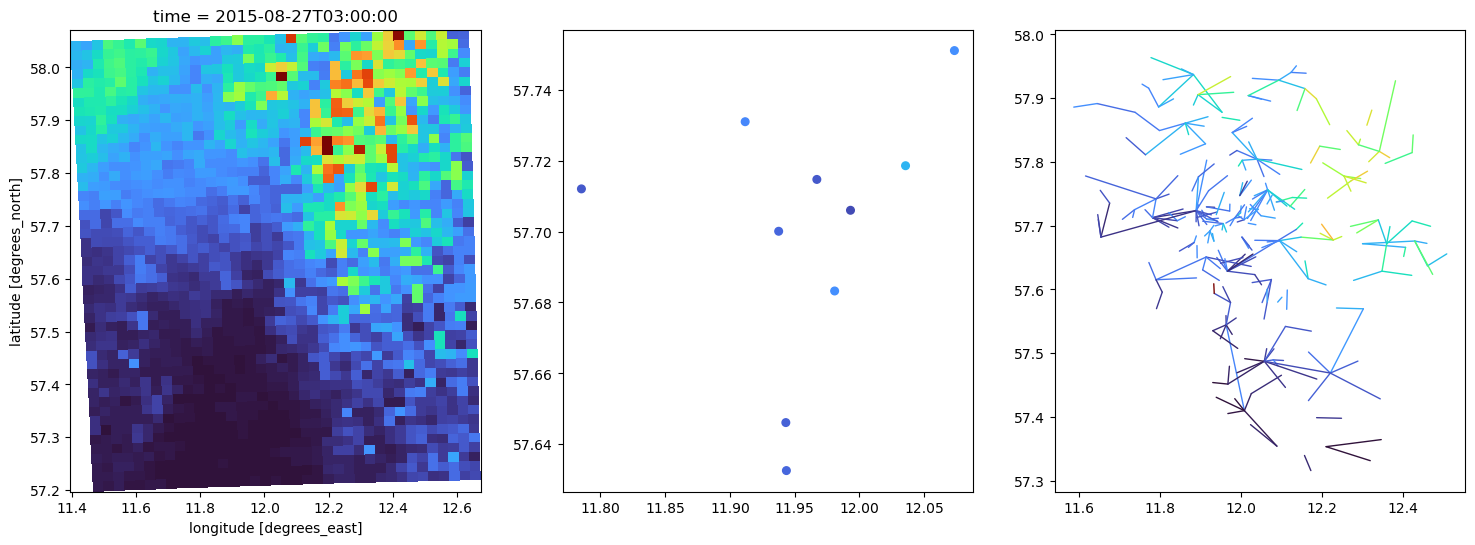

In [8]:
t = '2015-08-27T03:00:00'
vmin = 0
vmax = 10
cmap = 'turbo'

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
ds_radar_1h.sel(time=t).rainfall.plot(
    x='lon', y='lat', cmap=cmap, vmin=vmin, vmax=vmax, ax=axs[0], add_colorbar=False)
axs[1].scatter(
    ds_city_gauges.lon, 
    ds_city_gauges.lat, 
    c=ds_city_gauges_1h.sel(time=t).rainfall_amount,
    cmap='turbo', 
    vmin=vmin, 
    vmax=vmax, 
    s=30,
)
ds_cmls_1h.sel(time=t).plg.plot_cmls(
    vmin=vmin,
    vmax=vmax,
    cmap='turbo',
    ax=axs[2]);

## Get radar data at points and at CMLs

In [9]:
get_grid_at_lines = plg.spatial.GridAtLines(da_gridded_data=ds_radar_1h, ds_line_data=ds_cmls)
radar_along_cml = get_grid_at_lines(da_gridded_data=ds_radar_1h.rainfall)

In [10]:
get_grid_at_points = plg.spatial.GridAtPoints(
    da_gridded_data=ds_radar_1h, 
    da_point_data=ds_city_gauges,
    nnear=9,
    stat='best',
)
radar_at_points = get_grid_at_points(
    da_gridded_data=ds_radar_1h.rainfall, 
    da_point_data=ds_city_gauges_1h.rainfall_amount,
)

## Plot radar data at point and CMLs, as well as diff to point and CML observaions

In [ ]:
t = '2015-08-27T03:00:00'
vmin = 0
vmax = 10
cmap = 'turbo'

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
ds_radar_1h.sel(time=t).rainfall.plot(
    x='lon', y='lat', cmap=cmap, vmin=vmin, vmax=vmax, ax=axs[0], add_colorbar=False)
axs[1].scatter(
    ds_city_gauges.lon, 
    ds_city_gauges.lat, 
    c=radar_at_points.sel(time=t),
    cmap='turbo', 
    vmin=vmin, 
    vmax=vmax, 
    s=30,
)
radar_along_cml.sel(time=t).plg.plot_cmls(
    vmin=vmin,
    vmax=vmax,
    cmap='turbo',
    ax=axs[2]);

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs[0].axis('off')
axs[1].scatter(
    ds_city_gauges.lon, 
    ds_city_gauges.lat, 
    c=ds_city_gauges_1h.rainfall_amount.sel(time=t),
    cmap='turbo', 
    vmin=vmin, 
    vmax=vmax, 
    s=30,
)

ds_cmls_1h.sel(time=t).plg.plot_cmls(
    vmin=vmin,
    vmax=vmax,
    cmap='turbo',
    ax=axs[2]);

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs[0].axis('off')
sc = axs[1].scatter(
    ds_city_gauges.lon, 
    ds_city_gauges.lat, 
    c=ds_city_gauges_1h.rainfall_amount.sel(time=t) - radar_at_points.sel(time=t),
    cmap='RdBu', 
    vmin=vmax/-10, 
    vmax=vmax/10, 
    s=30,
    edgecolor='k',
    linewidth=0.3,
)
(ds_cmls_1h.sel(time=t) - radar_along_cml.sel(time=t)).plg.plot_cmls(
    vmin=vmin/-10,
    vmax=vmax/10,
    cmap='RdBu',
    ax=axs[2]);
plt.colorbar(sc, ax=axs[0], label='sensor value - radar_at_sensor values')

## Do radar adjustment

In [ ]:
# TODO for simple additive adjustmenet
# - interpolate differences in space
# - add interpolate diff-field to radar field